In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 9s 1us/step


In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5) / 127.5

In [38]:
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

In [92]:
def create_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [93]:
def create_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [94]:
generator = create_generator_model()
discriminator = create_discriminator_model()

# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [95]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

### **Discriminator loss**

One with all real images and zero with all fake Generated Images

In [96]:
def discriminator_loss(fake_outputs,real_outputs):
    return cross_entropy(tf.ones_like(real_outputs),real_outputs) + cross_entropy(tf.zeros_like(fake_outputs),fake_outputs)

### **Generator loss**

optimally predict one with fake images. Thus, Loss between ones and what is predicted

In [97]:
def generator_loss(fake_outputs):
    return cross_entropy(tf.ones_like(fake_outputs),fake_outputs)

In [98]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [99]:
cp_dir = './training_cps'
cp_prefix = os.path.join(cp_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [100]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [101]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [102]:
def generate_images(gen, epoch):
    generated_image = gen(seed, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(generated_image.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_image[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./Generated Images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [103]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        generate_images(generator,epoch + 1)

        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = cp_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_and_save_images(generator,epochs)

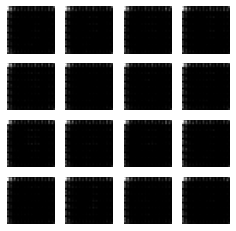

Time for epoch 1 is 17.1988365650177 sec


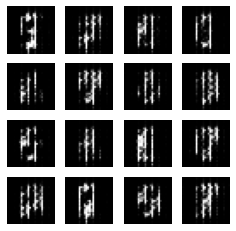

Time for epoch 2 is 13.716134071350098 sec


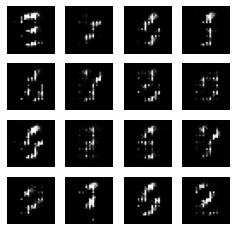

Time for epoch 3 is 14.979421854019165 sec


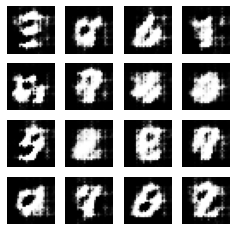

Time for epoch 4 is 15.072921514511108 sec


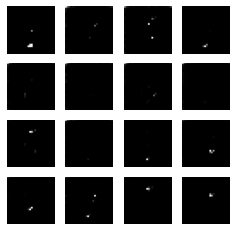

Time for epoch 5 is 11.85807728767395 sec


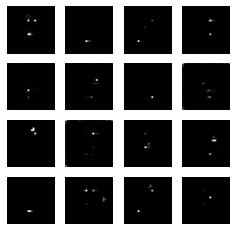

Time for epoch 6 is 10.653789520263672 sec


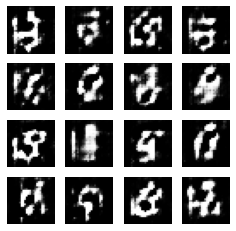

Time for epoch 7 is 10.816274404525757 sec


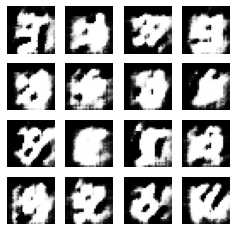

Time for epoch 8 is 10.599565267562866 sec


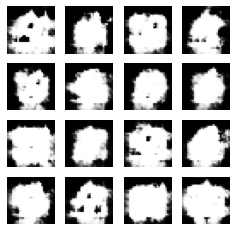

Time for epoch 9 is 10.604764699935913 sec


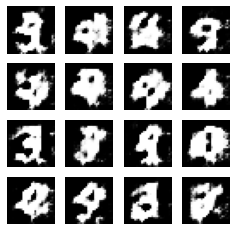

Time for epoch 10 is 10.629073143005371 sec


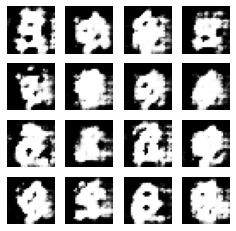

Time for epoch 11 is 10.65021800994873 sec


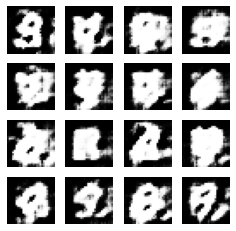

Time for epoch 12 is 10.912628412246704 sec


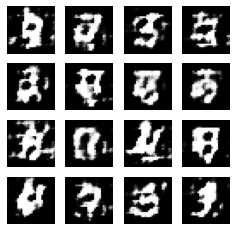

Time for epoch 13 is 10.187498092651367 sec


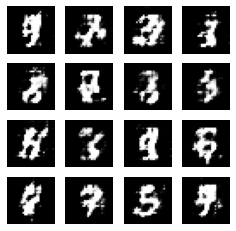

Time for epoch 14 is 15.220076560974121 sec


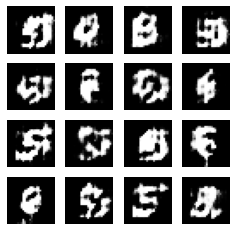

Time for epoch 15 is 15.129131555557251 sec


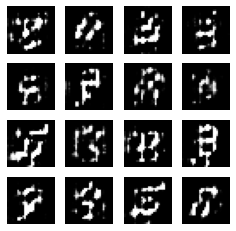

Time for epoch 16 is 11.59096384048462 sec


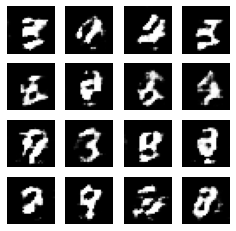

Time for epoch 17 is 10.633663892745972 sec


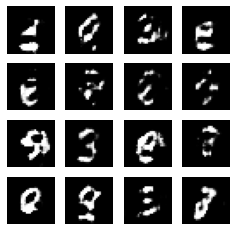

Time for epoch 18 is 10.035389423370361 sec


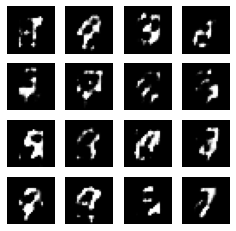

Time for epoch 19 is 10.198336362838745 sec


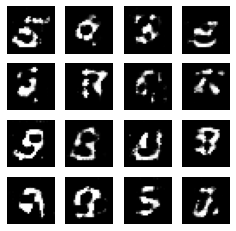

Time for epoch 20 is 13.540192604064941 sec


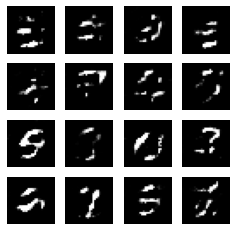

Time for epoch 21 is 10.763852596282959 sec


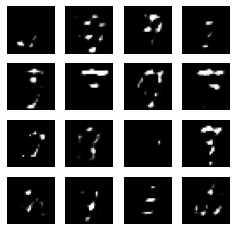

Time for epoch 22 is 10.782869338989258 sec


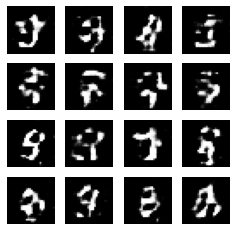

Time for epoch 23 is 10.679661273956299 sec


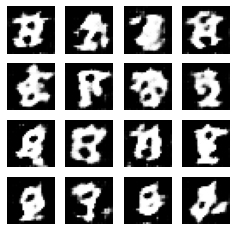

Time for epoch 24 is 10.951083421707153 sec


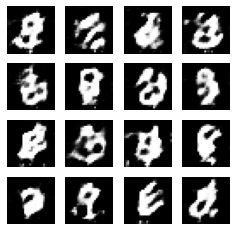

Time for epoch 25 is 10.714610576629639 sec


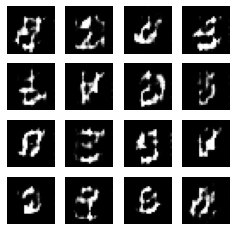

Time for epoch 26 is 10.287795782089233 sec


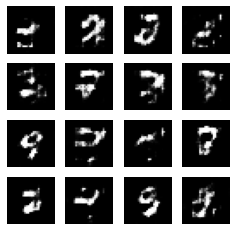

Time for epoch 27 is 9.787251472473145 sec


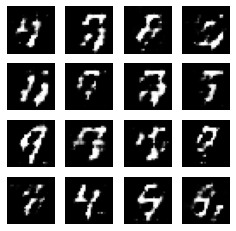

Time for epoch 28 is 10.691425800323486 sec


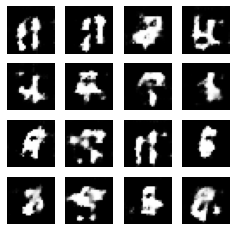

Time for epoch 29 is 14.9798424243927 sec


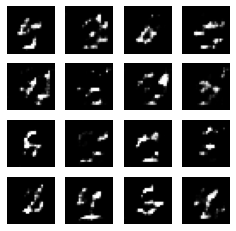

Time for epoch 30 is 14.213316440582275 sec


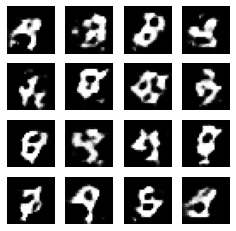

Time for epoch 31 is 10.646522521972656 sec


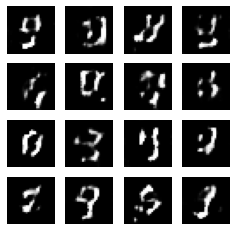

Time for epoch 32 is 10.673198223114014 sec


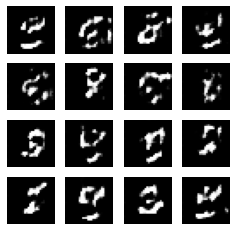

Time for epoch 33 is 10.671482563018799 sec


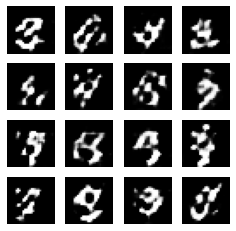

Time for epoch 34 is 10.675983190536499 sec


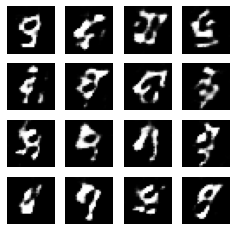

Time for epoch 35 is 13.077629804611206 sec


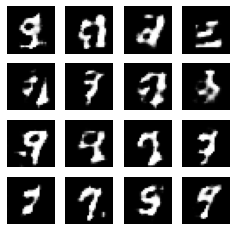

Time for epoch 36 is 12.368508577346802 sec


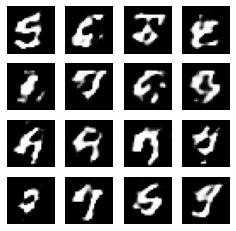

Time for epoch 37 is 16.30008602142334 sec


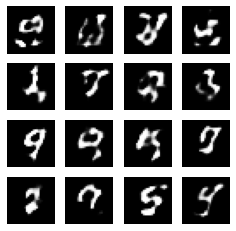

Time for epoch 38 is 15.774951696395874 sec


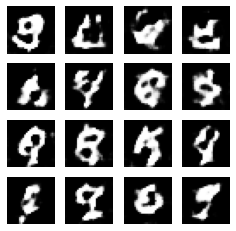

Time for epoch 39 is 14.53662371635437 sec


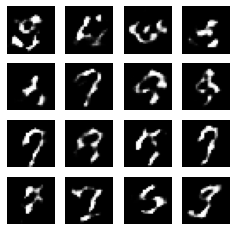

Time for epoch 40 is 11.2106773853302 sec


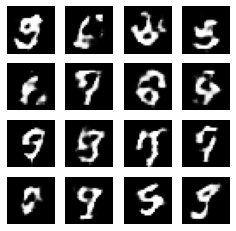

Time for epoch 41 is 10.658560991287231 sec


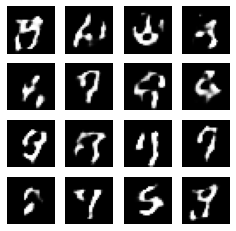

Time for epoch 42 is 12.24053430557251 sec


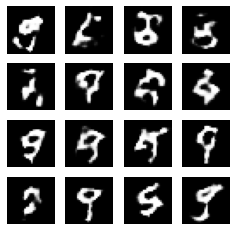

Time for epoch 43 is 15.360972166061401 sec


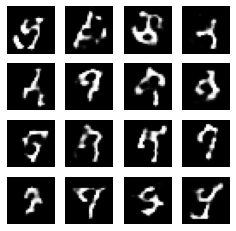

Time for epoch 44 is 15.628668785095215 sec


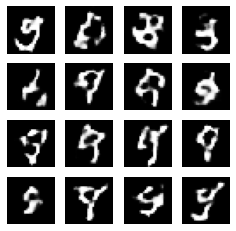

Time for epoch 45 is 15.458066463470459 sec


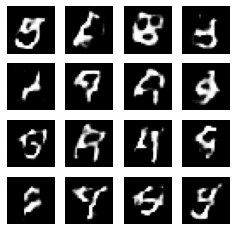

Time for epoch 46 is 15.31384801864624 sec


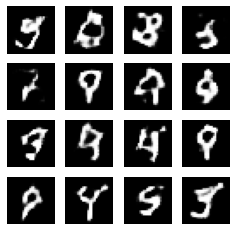

Time for epoch 47 is 15.068427324295044 sec


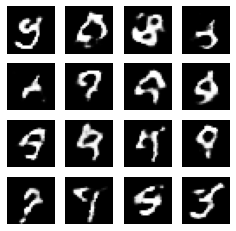

Time for epoch 48 is 15.30631136894226 sec


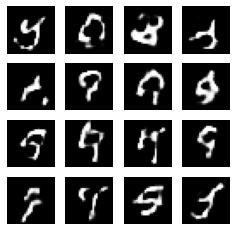

Time for epoch 49 is 15.659992218017578 sec


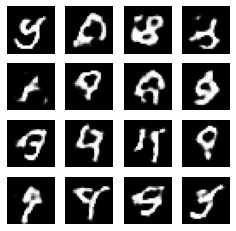

Time for epoch 50 is 14.987382650375366 sec


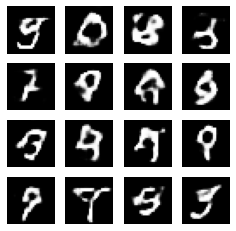

Time for epoch 51 is 15.030884981155396 sec


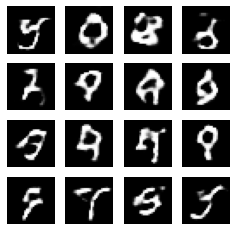

Time for epoch 52 is 15.115407943725586 sec


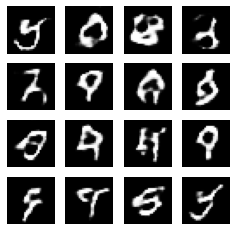

Time for epoch 53 is 15.028881072998047 sec


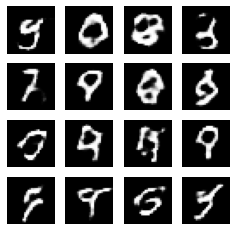

Time for epoch 54 is 15.369477033615112 sec


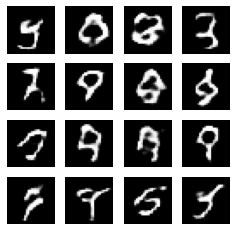

Time for epoch 55 is 15.096500158309937 sec


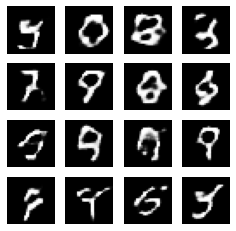

Time for epoch 56 is 15.058003425598145 sec


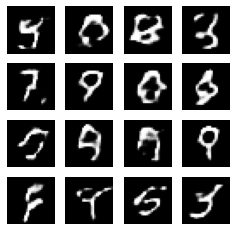

Time for epoch 57 is 15.611292123794556 sec


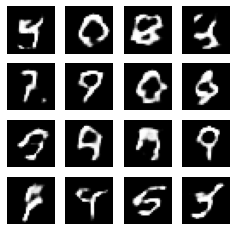

Time for epoch 58 is 14.079096794128418 sec


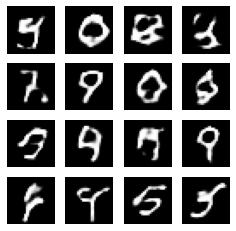

Time for epoch 59 is 13.296891212463379 sec


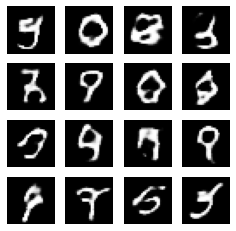

Time for epoch 60 is 16.19518542289734 sec


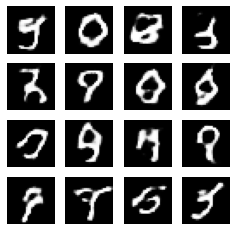

Time for epoch 61 is 15.136149406433105 sec


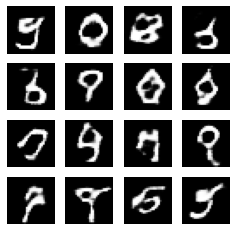

Time for epoch 62 is 14.961453437805176 sec


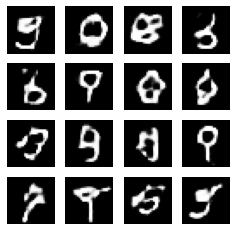

Time for epoch 63 is 14.958477020263672 sec


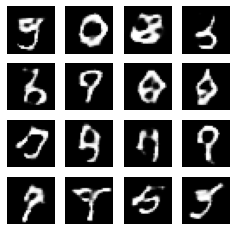

Time for epoch 64 is 15.03470754623413 sec


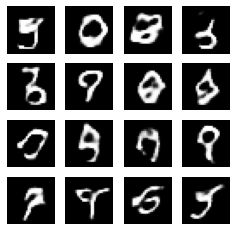

Time for epoch 65 is 14.23600721359253 sec


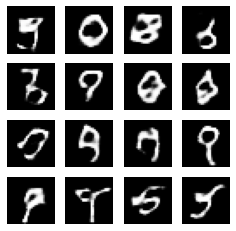

Time for epoch 66 is 15.280812978744507 sec


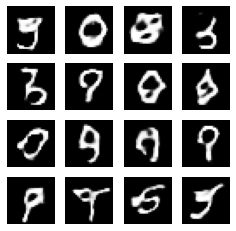

Time for epoch 67 is 15.077811002731323 sec


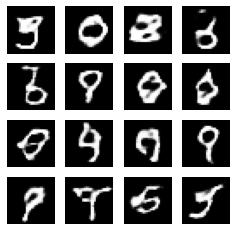

Time for epoch 68 is 15.186993837356567 sec


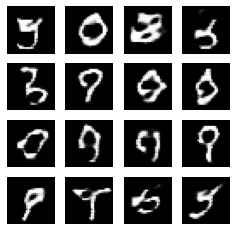

Time for epoch 69 is 15.064477443695068 sec


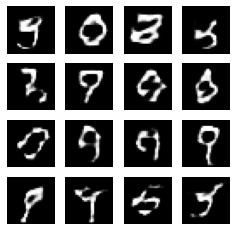

Time for epoch 70 is 15.150940895080566 sec


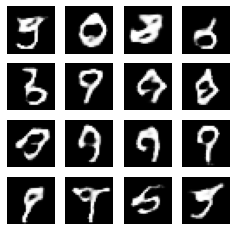

Time for epoch 71 is 15.016903162002563 sec


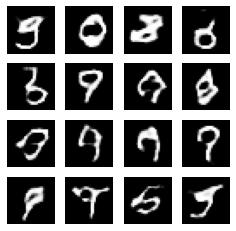

Time for epoch 72 is 15.348983526229858 sec


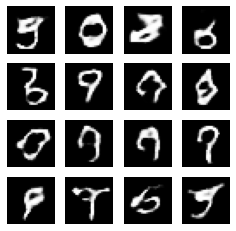

Time for epoch 73 is 15.234283208847046 sec


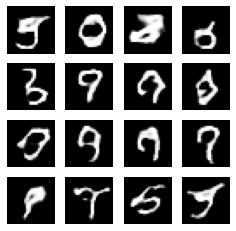

Time for epoch 74 is 14.99991750717163 sec


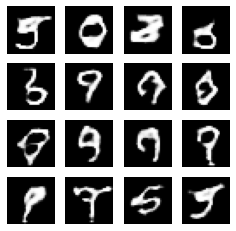

Time for epoch 75 is 15.102012157440186 sec


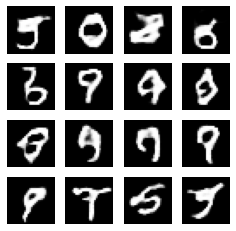

Time for epoch 76 is 15.069425344467163 sec


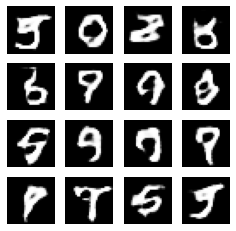

Time for epoch 77 is 15.003034353256226 sec


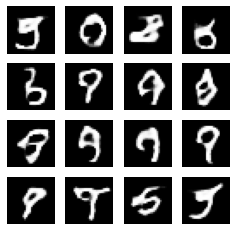

Time for epoch 78 is 15.268313884735107 sec


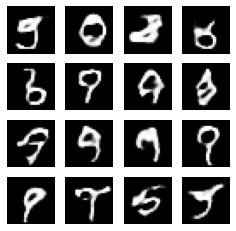

Time for epoch 79 is 14.967468738555908 sec


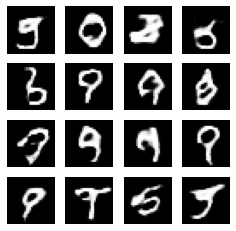

Time for epoch 80 is 15.634583473205566 sec


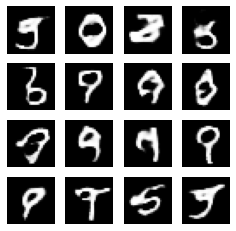

Time for epoch 81 is 15.003016710281372 sec


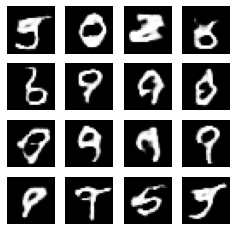

Time for epoch 82 is 15.048673868179321 sec


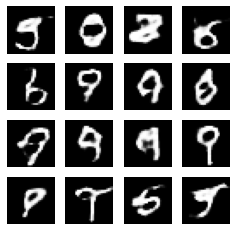

Time for epoch 83 is 15.032454013824463 sec


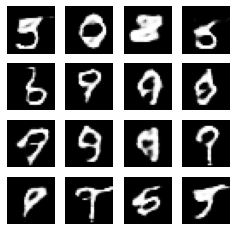

Time for epoch 84 is 15.21879768371582 sec


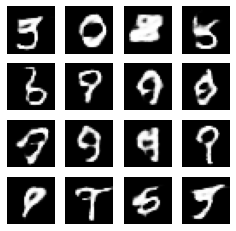

Time for epoch 85 is 15.00482439994812 sec


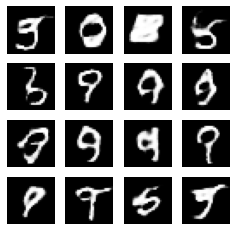

Time for epoch 86 is 14.977500200271606 sec


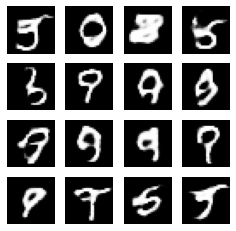

Time for epoch 87 is 14.97679090499878 sec


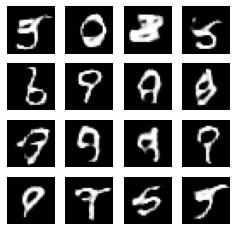

Time for epoch 88 is 15.026726722717285 sec


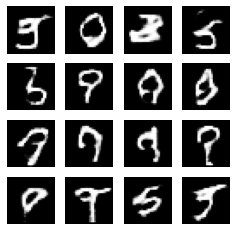

Time for epoch 89 is 15.014264583587646 sec


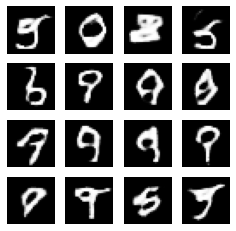

Time for epoch 90 is 15.297686338424683 sec


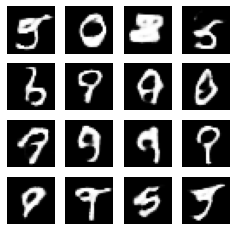

Time for epoch 91 is 15.041692733764648 sec


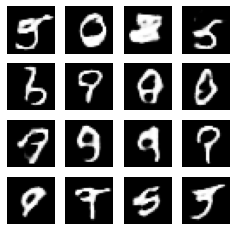

Time for epoch 92 is 14.989061117172241 sec


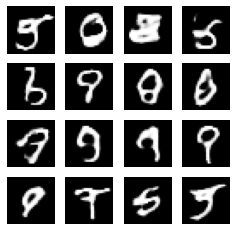

Time for epoch 93 is 14.98504376411438 sec


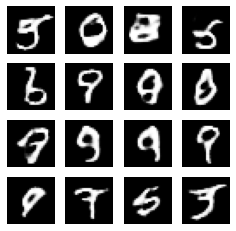

Time for epoch 94 is 15.060245990753174 sec


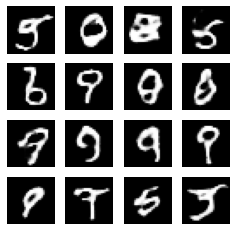

Time for epoch 95 is 15.006153583526611 sec


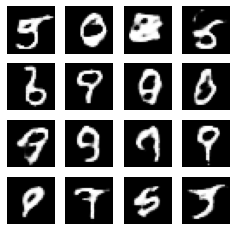

Time for epoch 96 is 15.280418395996094 sec


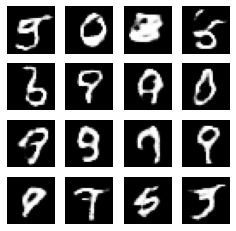

Time for epoch 97 is 15.038446187973022 sec


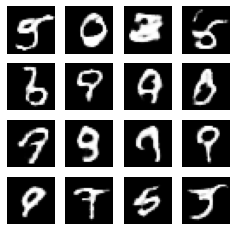

Time for epoch 98 is 14.992772579193115 sec


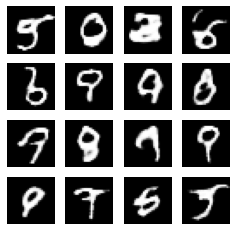

Time for epoch 99 is 15.274681091308594 sec


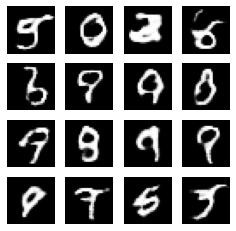

Time for epoch 100 is 15.695960998535156 sec


NameError: name 'generate_and_save_images' is not defined

In [104]:
train(train_dataset, EPOCHS)